In [119]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [120]:
d = 1

dataset = torch.cat([torch.randn(64, d) - 3, torch.randn(64, d) + 3])

In [121]:
# # Copyright (c) 2017-2019 Uber Technologies, Inc.
# # SPDX-License-Identifier: Apache-2.0

import math
from functools import partial

import torch
import torch.nn as nn
from torch.distributions import Transform, constraints

from pyro.nn import DenseNN

from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule


# class ConditionedMatrixExponential(Transform):
#     domain = constraints.real_vector
#     codomain = constraints.real_vector
#     bijective = True

#     def __init__(self, weights=None, iterations=8, normalization="none", bound=None):
#         super().__init__(cache_size=1)
#         assert iterations > 0
#         self.weights = weights
#         self.iterations = iterations
#         self.normalization = normalization
#         self.bound = bound

#         # Currently, weight and spectral normalization are unimplemented. This doesn't effect the validity of the
#         # bijection, although applying these norms should improve the numerical conditioning of the approximation.
#         if normalization == "weight" or normalization == "spectral":
#             raise NotImplementedError("Normalization is currently not implemented.")
#         elif normalization != "none":
#             raise ValueError("Unknown normalization method: {}".format(normalization))

#     def _exp(self, x, M):
#         """
#         Performs power series approximation to the vector product of x with the
#         matrix exponential of M.
#         """
#         power_term = x.unsqueeze(-1)
#         y = x.unsqueeze(-1)
#         for idx in range(self.iterations):
#             power_term = torch.matmul(M, power_term) / (idx + 1)
#             y = y + power_term

#         return y.squeeze(-1)

#     def _trace(self, M):
#         """
#         Calculates the trace of a matrix and is able to do broadcasting over batch
#         dimensions, unlike `torch.trace`.

#         Broadcasting is necessary for the conditional version of the transform,
#         where `self.weights` may have batch dimensions corresponding the batch
#         dimensions of the context variable that was conditioned upon.
#         """
#         return M.diagonal(dim1=-2, dim2=-1).sum(-1)

#     def _call(self, x):
#         """
#         :param x: the input into the bijection
#         :type x: torch.Tensor
#         Invokes the bijection x => y; in the prototypical context of a
#         :class:`~pyro.distributions.TransformedDistribution` `x` is a sample from
#         the base distribution (or the output of a previous transform)
#         """

#         M = self.weights() if callable(self.weights) else self.weights
#         b = self.bias() if callable(self.bias) else self.bias
#         return self._exp(x, M) + b

#     def _inverse(self, y):
#         """
#         :param y: the output of the bijection
#         :type y: torch.Tensor
#         Inverts y => x.
#         """

#         M = self.weights() if callable(self.weights) else self.weights
#         b = self.bias() if callable(self.bias) else self.bias
#         return self._exp(y - b, -M)

#     def log_abs_det_jacobian(self, x, y):
#         """
#         Calculates the element-wise determinant of the log Jacobian
#         """

#         M = self.weights() if callable(self.weights) else self.weights
#         return self._trace(M)

# class MatrixExponential(ConditionedMatrixExponential, TransformModule):

#     domain = constraints.real_vector
#     codomain = constraints.real_vector
#     bijective = True

#     def __init__(self, input_dim, iterations=8, normalization="none", bound=None):
#         super().__init__(
#             iterations=iterations, normalization=normalization, bound=bound
#         )

#         self.weights = nn.Parameter(torch.Tensor(input_dim, input_dim))
#         self.bias = nn.Parameter(torch.zeros(input_dim))
#         self.reset_parameters()

#     def reset_parameters(self):
#             stdv = 1.0 / math.sqrt(self.weights.size(0))
#             self.weights.data.normal_(stdv)


In [4]:
class ShiftScale(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, biases=None, bound=None):
        super().__init__(cache_size=1)
        self.weights = weights
        self.biases = biases
        self.bound = bound

    def _call(self, x):
        a = self.weights() if callable(self.weights) else self.weights
        b = self.biases() if callable(self.biases) else self.biases
        return a * x + b

    def _inverse(self, y):

        a = self.weights() if callable(self.weights) else self.weights
        b = self.biases() if callable(self.biases) else self.biases

        return (y - b) / a

    def log_abs_det_jacobian(self, x, y):
        a = self.weights() if callable(self.weights) else self.weights
        ladj = a.abs().log()
        return ladj


class ShiftScaleTransform(ShiftScale, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, bound=None):
        super().__init__(bound=bound)

        self.weights = nn.Parameter(torch.ones(input_dim, input_dim))
        self.biases = nn.Parameter(torch.zeros(input_dim))
#         self.reset_parameters()

    def reset_parameters(self):
            stdv = 1.0 / math.sqrt(self.weights.size(0))
            self.weights.data.uniform_(1-stdv, 1+stdv)



In [5]:
x = torch.linspace(-32, 32, 128)

In [6]:
import torch.nn.functional as F

In [7]:
# class LeakyReLU(Transform):
#     domain = constraints.real_vector
#     codomain = constraints.real_vector
#     bijective = True

#     def __init__(self, a=None, bound=None):
#         super().__init__(cache_size=1)
#         self.a = a
#         self.bound = bound

#     def _call(self, x):
#         a = self.a() if callable(self.a) else self.a
#         return torch.maximum(a.exp() * x, x)

#     def _inverse(self, y):
#         a = self.a() if callable(self.a) else self.a
#         return torch.maximum(1 / a.exp() * y, y)

#     def log_abs_det_jacobian(self, x, y):
#         a = self.a() if callable(self.a) else self.a
#         return torch.where(
#             x >= 0.0, torch.zeros_like(x), torch.ones_like(x) * a
#         )




# class LeakyReLUTransform(LeakyReLU, TransformModule):

#     domain = constraints.real_vector
#     codomain = constraints.real_vector
#     bijective = True

#     def __init__(self, input_dim, bound=None):
#         super().__init__(bound=bound)

#         self.a = nn.Parameter(torch.zeros(1))


In [185]:
def leaky_relu(x, alpha):
    return torch.maximum(torch.tensor(0.), x) + alpha * torch.minimum(torch.tensor(0.), x)


# class LeakyReLUTransform(Transform):
#     r"""
#     Bijective transform via the mapping :math:`y = \text{LeakyReLU}(x)`.
#     """
#     domain = constraints.real
#     codomain = constraints.positive
#     bijective = True
#     sign = +1
#     def __init__(self, bound=None, alpha=torch.tensor(0.)):
#         super().__init__()
#         self.alpha = alpha
#         self.bound = bound
    
#     def __eq__(self, other):
#         return isinstance(other, LeakyReLUTransform)

#     def _call(self, x):
#         return leaky_relu(x, self.alpha.exp())

#     def _inverse(self, y):
#         return leaky_relu(y, 1 / self.alpha.exp())

#     def log_abs_det_jacobian(self, x, y):
#         return torch.where(
#             x >= 0.0, torch.zeros_like(x), torch.ones_like(x) * self.alpha
#         )

# class LeakyReLUTransformModule(LeakyReLUTransform, TransformModule):

#     domain = constraints.real_vector
#     codomain = constraints.real_vector
#     bijective = True

#     def __init__(self, bound=None):
#         super().__init__(bound)

#         self.a = nn.Parameter(torch.zeros(1))



In [186]:
def hinge(x):
    return 1 / 1.872675895690918 * (x + x.sgn() * x.abs().sqrt())

In [187]:
z = torch.randn(32768)

In [188]:
hinge(z).std().item()

0.9976516962051392

<AxesSubplot:ylabel='Density'>

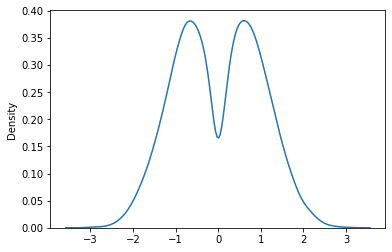

In [189]:
sns.kdeplot(hinge(z))

In [116]:
def inv_hinge(y):
    y = y.clone()
    y[y > 0] = y[y > 0] ** 2
    y[y < 0] = -y[y < 0] ** 2
    return y

<AxesSubplot:ylabel='Density'>

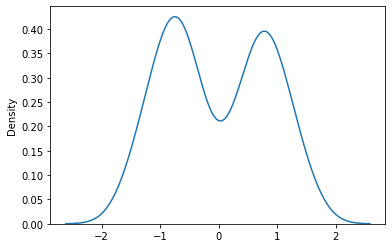

In [117]:
z_ = hinge(z)
sns.kdeplot(hinge(z))
# sns.kdeplot(z_)

<AxesSubplot:ylabel='Density'>

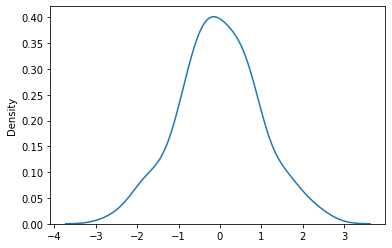

In [118]:
sns.kdeplot(inv_hinge(hinge(z)))

In [88]:
z__ = hinge(-z_, 4)

TypeError: hinge() takes 1 positional argument but 2 were given

<AxesSubplot:ylabel='Density'>

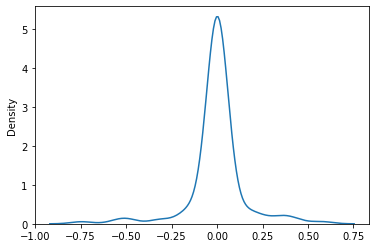

In [53]:
sns.kdeplot(z__)

In [9]:
class LeakyReLUTransform(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, alpha=None, bound=None):
        super().__init__(cache_size=1)
        self.alpha = alpha
        self.bound = bound

    def _call(self, x):
        return leaky_relu(x, self.alpha.exp())

    def _inverse(self, y):
        return leaky_relu(y, 1 / self.alpha.exp())

    def log_abs_det_jacobian(self, x, y):
        return torch.where(
            x >= 0.0, torch.zeros_like(x), torch.ones_like(x) * self.alpha
        )



class LeakyReLUTransformModule(LeakyReLUTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, bound=None):
        super().__init__(bound=bound)

        self.alpha = nn.Parameter(torch.FloatTensor((.9,)))


In [10]:
    base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 32
transform = []
for l in range(num_layers - 1):
    transform.append(ShiftScaleTransform(d))
#     transform.append(MatrixExponential(d))
#     transform.append(T.SoftplusTransform())
    transform.append(LeakyReLUTransformModule())
#     transform.append(T.ELUTransform())
transform.append(ShiftScaleTransform(d))
# transform.append(MatrixExponential(d))


transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)


In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [12]:
# matexp = MatrixExponential(d)

In [13]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_prob(flow_dist, dataset)

ShiftScaleTransform() tensor(0.0840, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(0.9663, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(0.9663, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.3250, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.3250, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.4709, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.4709, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.5302, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.5302, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.5543, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.5543, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.5641, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.5641, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1.5681, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(1.5681, grad_fn=<MeanBackward0>)
LeakyReLUTransformModule() tensor(1

tensor([[-28.8189, -28.8189, -28.8189,  ..., -37.5170, -38.0142, -34.3305],
        [-28.8189, -28.8189, -28.8189,  ..., -37.5170, -38.0142, -34.3305],
        [-28.8189, -28.8189, -28.8189,  ..., -37.5170, -38.0142, -34.3305],
        ...,
        [ -0.9189,  -0.9189,  -0.9189,  ...,  -9.6170, -10.1142,  -6.4305],
        [ -0.9189,  -0.9189,  -0.9189,  ...,  -9.6170, -10.1142,  -6.4305],
        [ -0.9189,  -0.9189,  -0.9189,  ...,  -9.6170, -10.1142,  -6.4305]],
       grad_fn=<AddBackward0>)

In [14]:
# print(count_parameters(transform_modules))

In [15]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


In [16]:
steps = 16384
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


step: 0, loss: 17.63787841796875
step: 500, loss: 2.5036184787750244
step: 1000, loss: 2.5170822143554688
step: 1500, loss: 2.5526392459869385
step: 2000, loss: 2.5951578617095947
step: 2500, loss: 2.5973448753356934
step: 3000, loss: 2.606534242630005
step: 3500, loss: 2.595998525619507
step: 4000, loss: 2.595198392868042
step: 4500, loss: 2.595172882080078
step: 5000, loss: 2.5952255725860596
step: 5500, loss: 2.5951578617095947
step: 6000, loss: 2.5951597690582275
step: 6500, loss: 2.595170021057129
step: 7000, loss: 2.5951569080352783
step: 7500, loss: 2.595158100128174
step: 8000, loss: 2.6187729835510254
step: 8500, loss: 2.595158100128174
step: 9000, loss: 2.5951590538024902
step: 9500, loss: 2.595160961151123
step: 10000, loss: 2.5980594158172607
step: 10500, loss: 2.600238800048828


KeyboardInterrupt: 

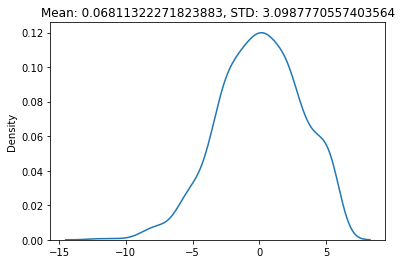

In [17]:
with torch.no_grad():
    sample = flow_dist.sample((1000,)).squeeze().numpy()
    sns.kdeplot(sample)
    plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")

<AxesSubplot:ylabel='Density'>

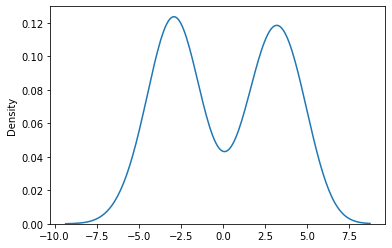

In [18]:
sns.kdeplot(dataset.squeeze())